In [ ]:
from google.colab import files
files.upload()  # Burada "kaggle.json" dosyasını seçin


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zehraerva","key":"c50b68fb59310f2fef7adc73186b1a92"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
!kaggle datasets download -d borhanitrash/alzheimer-mri-disease-classification-dataset


Dataset URL: https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset
License(s): apache-2.0
100% 26.0M/26.0M [00:01<00:00, 28.1MB/s]
100% 26.0M/26.0M [00:01<00:00, 16.1MB/s]


In [ ]:
!unzip alzheimer-mri-disease-classification-dataset.zip -d ./alzheimer_data


Archive:  alzheimer-mri-disease-classification-dataset.zip
  inflating: ./alzheimer_data/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet  
  inflating: ./alzheimer_data/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet  
  inflating: ./alzheimer_data/Alzheimer MRI Disease Classification Dataset/README.md  


In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import os



In [ ]:
# Parquet dosyalarının bulunduğu dizin
data_dir = './alzheimer_data/Alzheimer MRI Disease Classification Dataset/Data'

# Eğitim ve test verilerini oku
train_file = os.path.join(data_dir, 'train-00000-of-00001-c08a401c53fe5312.parquet')
test_file = os.path.join(data_dir, 'test-00000-of-00001-44110b9df98c5585.parquet')

# Parquet dosyalarını Pandas DataFrame olarak yükle
train_data = pd.read_parquet(train_file)
test_data = pd.read_parquet(test_file)

# Veri çerçevelerini kontrol et
print(train_data.head())
print(test_data.head())


                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0


In [ ]:
import io
from PIL import Image
import numpy as np

# Görüntüleri çözümleme (decode) ve uygun boyuta getirme
def decode_image(byte_data):
    # Bayt dizisini Pillow görüntüsüne çevir
    image = Image.open(io.BytesIO(byte_data['bytes']))
    # Görüntüyü yeniden boyutlandır
    image = image.resize((150, 150))  # CNN için standart boyut
    return np.array(image)

# Tüm görüntüleri işleyelim
X_train = np.array([decode_image(img) for img in train_data['image']])
X_test = np.array([decode_image(img) for img in test_data['image']])

# Görüntüleri normalize edin
X_train = X_train / 255.0
X_test = X_test / 255.0


In [ ]:
from tensorflow.keras.utils import to_categorical

# Etiketleri kategorik hale getirin
y_train = to_categorical(train_data['label'], num_classes=4)  # Sınıf sayısını ayarlayın
y_test = to_categorical(test_data['label'], num_classes=4)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN modelini oluştur
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 sınıf olduğundan çıktı nöron sayısını 4 yapıyoruz
])

# Modeli derleyin
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model özetini yazdırın
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Giriş verilerine eksik olan renk kanalını ekleyin
X_train = X_train.reshape(X_train.shape[0], 150, 150, 1)  # 1 kanal (grayscale) ekleniyor
X_test = X_test.reshape(X_test.shape[0], 150, 150, 1)

# Modelin beklediği RGB formatına dönüştürmek isterseniz (örneğin, 3 kanal eklemek için):
# X_train = np.repeat(X_train, 3, axis=-1)
# X_test = np.repeat(X_test, 3, axis=-1)


In [ ]:
# ipython-input-19-ffd3116c668e
# Modeli gri tonlamalı görüntüler için yeniden tanımlayın
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),  # 1 kanal (grayscale)
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 sınıf
])

# Modeli derleyin (Bu satırı ekleyin)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32
)


Epoch 1/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.4645 - loss: 1.0982 - val_accuracy: 0.5492 - val_loss: 0.9311
Epoch 2/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.5877 - loss: 0.8890 - val_accuracy: 0.6570 - val_loss: 0.7835
Epoch 3/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.6488 - loss: 0.7658 - val_accuracy: 0.7281 - val_loss: 0.6238
Epoch 4/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.7527 - loss: 0.5688 - val_accuracy: 0.8094 - val_loss: 0.4788
Epoch 5/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8386 - loss: 0.3792 - val_accuracy: 0.8828 - val_loss: 0.3094
Epoch 6/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.8902 - loss: 0.2855 - val_accuracy: 0.9195 - val_loss: 0.2247
Epoch 7/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9243 - loss: 0.1961 - val_accuracy: 0.9281 - val_loss: 0.2109
Epoch 8/25
160/160 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.9434 - loss: 0.1489 - val_accu

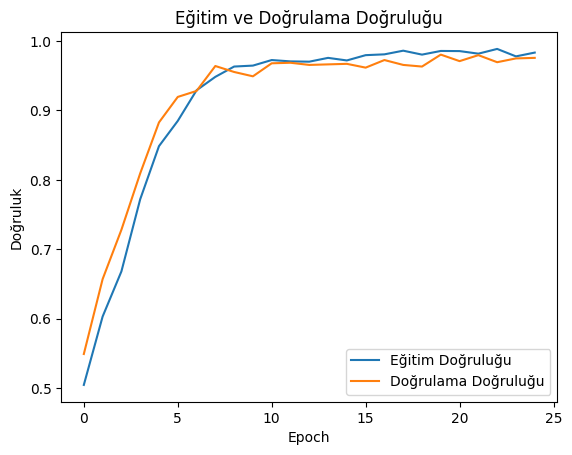

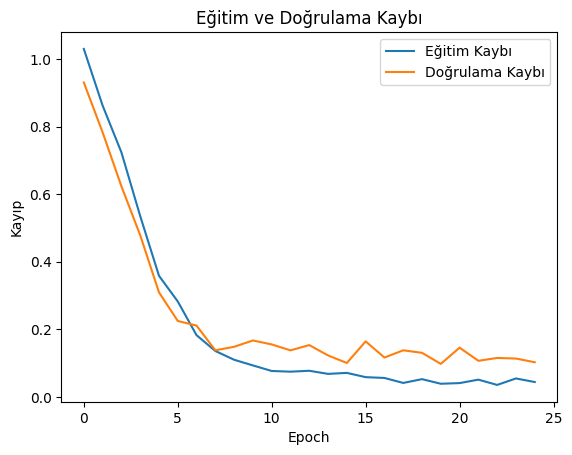

In [ ]:
import matplotlib.pyplot as plt

# Doğruluk grafiği
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.show()

# Kayıp grafiği
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Kaybı: {test_loss}")
print(f"Test Doğruluğu: {test_accuracy}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 464ms/step - accuracy: 0.9740 - loss: 0.1264
Test Kaybı: 0.10239459574222565
Test Doğruluğu: 0.975781261920929


In [ ]:
# Bir test örneği için tahmin
import numpy as np

sample_image = X_test[0]  # Test verisinden bir örnek alın
sample_label = y_test[0]  # Gerçek etiket

# Giriş boyutunu modele uygun hale getirin
sample_image = np.expand_dims(sample_image, axis=0)

# Tahmin
predicted = model.predict(sample_image)
predicted_class = np.argmax(predicted, axis=1)

print(f"Tahmin Edilen Sınıf: {predicted_class}")
print(f"Gerçek Sınıf: {np.argmax(sample_label)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Tahmin Edilen Sınıf: [3]
Gerçek Sınıf: 3


X_test shape: (1280, 150, 150, 1)
Bir örnek görüntünün minimum ve maksimum piksel değerleri: 0.0, 1.0


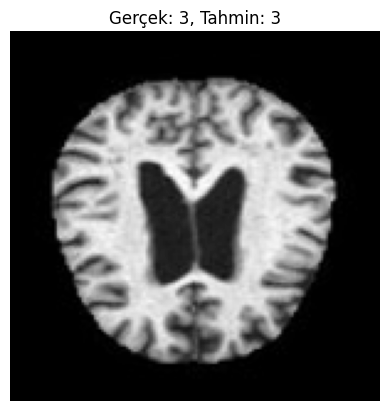

In [ ]:
print(f"X_test shape: {X_test.shape}")
print(f"Bir örnek görüntünün minimum ve maksimum piksel değerleri: {X_test[0].min()}, {X_test[0].max()}")

plt.imshow(X_test[0].reshape(150, 150), cmap='gray')  # Gri tonlamalı görüntü
plt.title(f"Gerçek: {np.argmax(y_test[0])}, Tahmin: {predicted_labels[0]}")
plt.axis("off")
plt.show()



40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step


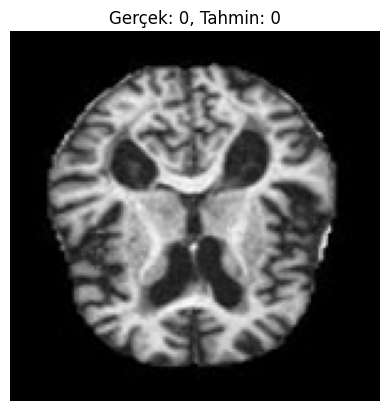

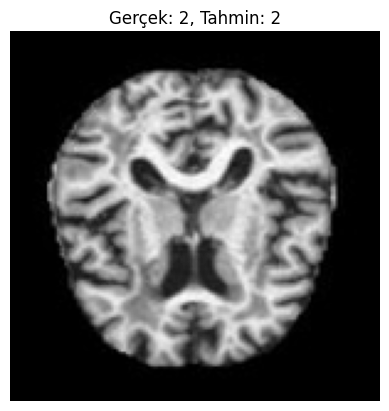

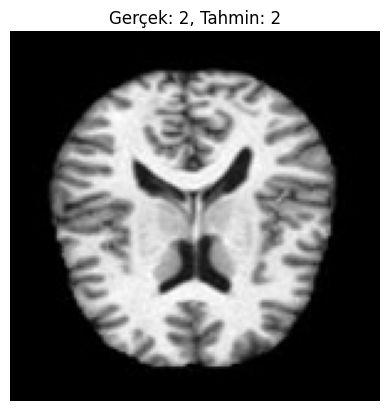

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tahminler yapın
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Random 3 test MR görüntüsünü tahminle görselleştirme
random_indices = np.random.choice(len(X_test), 3, replace=False)  # Rastgele 3 indeks seç

for i in random_indices:
    plt.imshow(X_test[i].reshape(150, 150), cmap='gray')  # Gri tonlamalı görüntü
    plt.title(f"Gerçek: {np.argmax(y_test[i])}, Tahmin: {predicted_labels[i]}")
    plt.axis("off")
    plt.show()


In [ ]:
model.save('my_model.keras')



In [ ]:
import os
print(os.listdir('.'))



['.config', 'alzheimer_cnn_model.h5', 'alzheimer-mri-disease-classification-dataset.zip', 'my_model.keras', 'alzheimer_data', 'kaggle.json', 'sample_data']
